In [6]:
import pandas as pd
import torch
import gc

In [7]:
if torch.cuda.is_available():
    print("CUDA is available. GPU will be used for inference.")
else:
    print("CUDA is not available. Inference will run on CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# load the datasets
df = pd.read_excel("D:\CJ\course\大四下\\final project\ARO\processed_data.xlsx")

texts = df["Content"].tolist()

CUDA is not available. Inference will run on CPU.


In [8]:
from transformers import AutoTokenizer, AutoModel
import torch


# extract embeddings
def get_embeddings(model_name, texts, max_length=128, batch_size=32):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()  # set model to evaluation mode 
    
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', max_length=max_length, truncation=True, padding='max_length').to(device)
        
        with torch.no_grad():  # do not calculate gradients to save memory
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)  # use mean pooling
            embeddings.append(batch_embeddings)
            del inputs, outputs, batch_embeddings  # Free up memory
            gc.collect()
            
    embeddings_tensor = torch.cat(embeddings, dim=0)
    return embeddings_tensor

# use mBERT model to extract embeddings
mbert_embeddings = get_embeddings('bert-base-multilingual-cased', texts)

# use XLM-R model to extract embeddings
xlmr_embeddings = get_embeddings('xlm-roberta-base', texts)




tokenizer_config.json: 100%|██████████| 25.0/25.0 [00:00<?, ?B/s]
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lenovo\.cache\huggingface\hub\models--xlm-roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
config.json: 100%|████████

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


轮廓系数: 0.38


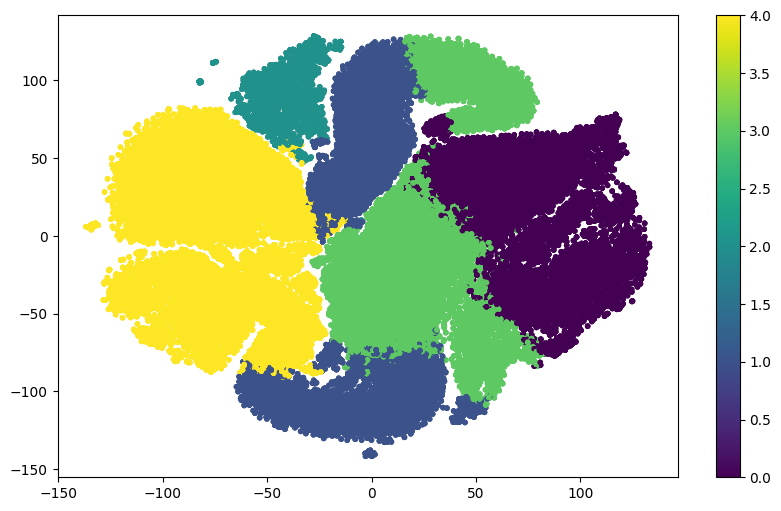

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


轮廓系数: 0.18


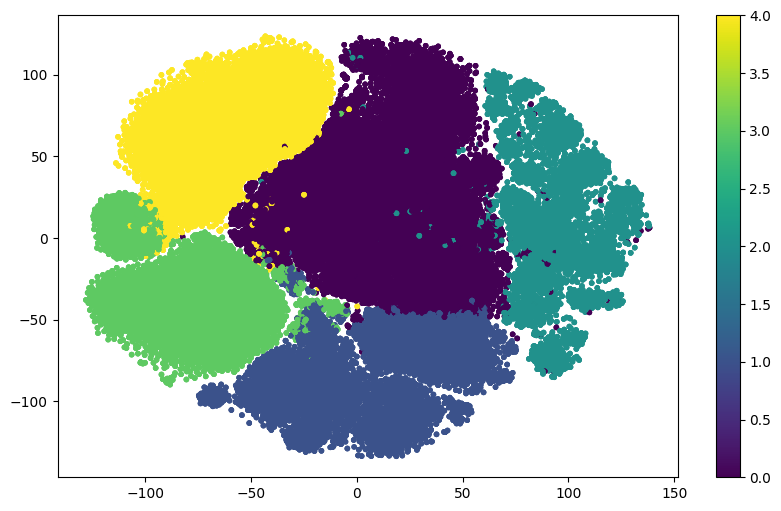

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def cluster_embeddings(embeddings, n_clusters=5):
    # use K-Means to cluster embeddings
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embeddings)
    labels = kmeans.labels_
    
    # calculate silhouette score
    silhouette_avg = silhouette_score(embeddings, labels)
    print(f"silhouette score: {silhouette_avg:.2f}")
    
    return labels

def visualize_embeddings(embeddings, labels):
    # use t-SNE to reduce dimensionality 
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    
    # visualize
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', marker='.')
    plt.colorbar()
    plt.show()

# xlmr_embeddings are embeddings of XLM-R model
xlmr_labels = cluster_embeddings(xlmr_embeddings)
visualize_embeddings(xlmr_embeddings, xlmr_labels)

mbert_labels = cluster_embeddings(mbert_embeddings)
visualize_embeddings(mbert_embeddings, mbert_labels)
